In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

# --- CONFIGURATION ---
POPULATION_DATA_PATH = "../data/rewari_village_population_2011.csv"
GEOGRAPHY_DATA_PATH = "../data/rewari_boundary.geojson"

# --- LOAD DATA ---
print("Loading datasets...")
# Load village population data
df_population = pd.read_csv(POPULATION_DATA_PATH)

# Load the district boundary
gdf_district = gpd.read_file(GEOGRAPHY_DATA_PATH)

print("Datasets loaded successfully.")

# --- VERIFICATION ---
print("\nDistrict Boundary Info:")
gdf_district.info()

print("\nPopulation Data Info:")
df_population.info()

print("\nFirst 5 villages:")
display(df_population.head())

Loading datasets...
Datasets loaded successfully.

District Boundary Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_2      1 non-null      object  
 1   GID_0      1 non-null      object  
 2   COUNTRY    1 non-null      object  
 3   GID_1      1 non-null      object  
 4   NAME_1     1 non-null      object  
 5   NL_NAME_1  1 non-null      object  
 6   NAME_2     1 non-null      object  
 7   VARNAME_2  1 non-null      object  
 8   NL_NAME_2  1 non-null      object  
 9   TYPE_2     1 non-null      object  
 10  ENGTYPE_2  1 non-null      object  
 11  CC_2       1 non-null      object  
 12  HASC_2     1 non-null      object  
 13  geometry   1 non-null      geometry
dtypes: geometry(1), object(13)
memory usage: 244.0+ bytes

Population Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data c

,loc_code,village_name,total_households,total_population
0,62518,Gangoli(135),235.0,5.0
1,62519,Saharanwas (130),174.0,462.0
2,62520,Ladhuwas Ahir (129),171.0,275.0
3,62521,Khargwas (127),233.0,252.0
4,62522,Balawas Ahir (128),163.0,322.0


--- Starting Geocoding Process ---
This will take about 6-7 minutes. Please be patient.

--- Geocoding Complete ---
Successfully found coordinates for 22 out of 213 villages.

--- Starting Simulation ---

Populating the world with agents...
Population complete. Created 7377 agents.
Day 1/150 | S: 7365, I: 12, R: 0
Day 2/150 | S: 7360, I: 17, R: 0
Day 3/150 | S: 7355, I: 22, R: 0
Day 4/150 | S: 7352, I: 25, R: 0
Day 5/150 | S: 7345, I: 32, R: 0
Day 6/150 | S: 7330, I: 47, R: 0
Day 7/150 | S: 7317, I: 60, R: 0
Day 8/150 | S: 7303, I: 74, R: 0
Day 9/150 | S: 7286, I: 91, R: 0
Day 10/150 | S: 7259, I: 118, R: 0
Day 11/150 | S: 7219, I: 158, R: 0
Day 12/150 | S: 7191, I: 186, R: 0
Day 13/150 | S: 7159, I: 218, R: 0
Day 14/150 | S: 7110, I: 257, R: 10
Day 15/150 | S: 7049, I: 316, R: 12
Day 16/150 | S: 7007, I: 353, R: 17
Day 17/150 | S: 6950, I: 405, R: 22
Day 18/150 | S: 6894, I: 458, R: 25
Day 19/150 | S: 6828, I: 517, R: 32
Day 20/150 | S: 6768, I: 562, R: 47
Day 21/150 | S: 6719, I: 598

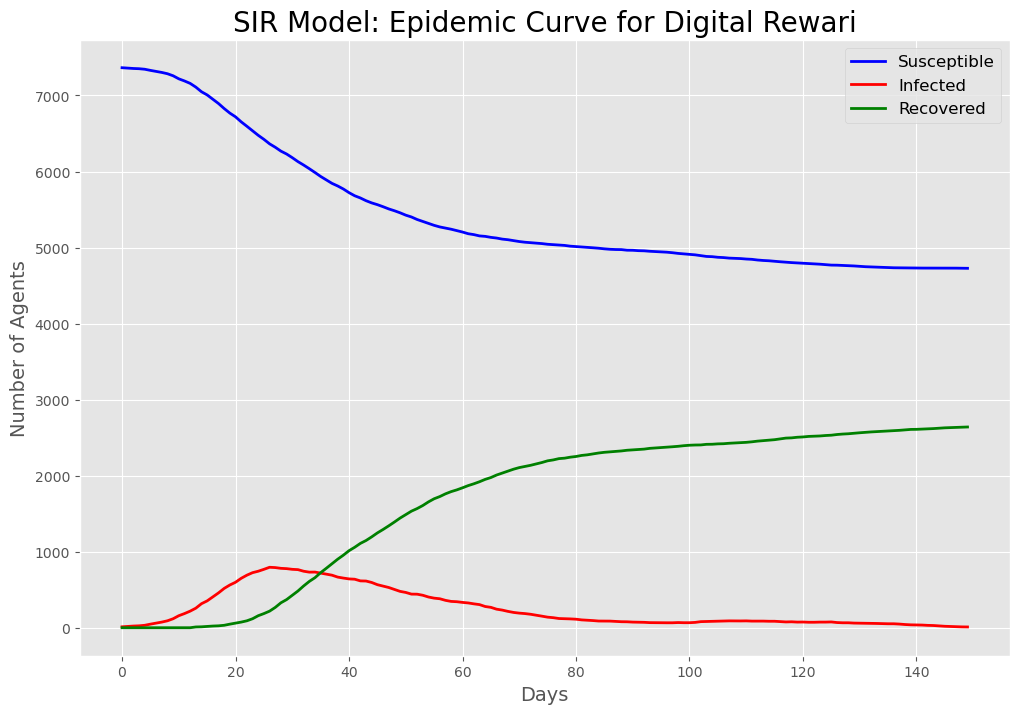

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy.spatial import cKDTree

# --- CONFIGURATION ---
POPULATION_DATA_PATH = "../data/rewari_village_population_2011_main.csv"
GEOGRAPHY_DATA_PATH = "../data/rewari_boundary.geojson"

# --- SIMULATION PARAMETERS ---
INFECTION_RADIUS = 0.001
INFECTION_PROBABILITY = 0.05
RECOVERY_DURATION = 14
INITIAL_INFECTIONS = 10

# --- DATA LOADING & GEOCODING ---

def load_and_geocode_villages(population_path):
    """Loads village population data and finds their geographic coordinates."""
    df_pop = pd.read_csv(population_path)
    
    # --- FIX: Ensure all village names are treated as strings to prevent errors ---
    df_pop['village_name'] = df_pop['village_name'].astype(str)
    # ---------------------------------------------------------------------------
    
    print("--- Starting Geocoding Process ---")
    print("This will take about 6-7 minutes. Please be patient.")
    
    geolocator = Nominatim(user_agent="aetheria_h_simulation_v3")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, error_wait_seconds=5)

    locations = []
    for _, row in df_pop.iterrows():
        query = f"{row['village_name'].split('(')[0]}, Rewari, Haryana, India"
        try:
            location = geocode(query, timeout=10)
            if location:
                locations.append((location.latitude, location.longitude))
            else:
                locations.append((None, None))
        except Exception as e:
            print(f"Error geocoding {row['village_name']}: {e}")
            locations.append((None, None))
    
    df_pop[['latitude', 'longitude']] = locations
    
    successful_codes = df_pop['latitude'].notna().sum()
    print(f"\n--- Geocoding Complete ---")
    print(f"Successfully found coordinates for {successful_codes} out of {len(df_pop)} villages.")
    
    return df_pop

# --- CLASS DEFINITIONS ---

class Agent:
    def __init__(self, agent_id, x, y):
        self.id = agent_id
        self.x = x
        self.y = y
        self.status = 'S' # Susceptible
        self.infection_timer = 0

class World:
    def __init__(self, district_geography, village_data):
        self.gdf_district = district_geography
        self.df_villages = village_data.dropna(subset=['latitude', 'longitude']).copy()
        self.agents = []
        self.history = []

    def populate(self):
        print("\nPopulating the world with agents...")
        agent_id_counter = 0
        spread_radius = 0.005 

        for _, village in self.df_villages.iterrows():
            village_pop = int(village['total_population'])
            for _ in range(village_pop):
                agent_x = village['longitude'] + np.random.normal(0, spread_radius)
                agent_y = village['latitude'] + np.random.normal(0, spread_radius)
                self.agents.append(Agent(agent_id_counter, agent_x, agent_y))
                agent_id_counter += 1
        
        print(f"Population complete. Created {len(self.agents)} agents.")

    def seed_infection(self, num_infections):
        infected_indices = np.random.choice(len(self.agents), num_infections, replace=False)
        for i in infected_indices:
            self.agents[i].status = 'I' # Infected
            self.agents[i].infection_timer = RECOVERY_DURATION

    def tick(self):
        infected_agents = [a for a in self.agents if a.status == 'I']
        susceptible_agents = [a for a in self.agents if a.status == 'S']

        if not infected_agents: return

        for agent in infected_agents:
            agent.infection_timer -= 1
            if agent.infection_timer <= 0:
                agent.status = 'R'

        susceptible_coords = np.array([[a.x, a.y] for a in susceptible_agents])
        if susceptible_coords.shape[0] == 0: return
        
        susceptible_tree = cKDTree(susceptible_coords)
        newly_infected_ids = set()

        for agent_i in infected_agents:
            if agent_i.status != 'I': continue
            
            nearby_indices = susceptible_tree.query_ball_point([agent_i.x, agent_i.y], INFECTION_RADIUS)
            
            for index in nearby_indices:
                agent_s = susceptible_agents[index]
                if agent_s.id not in newly_infected_ids and np.random.rand() < INFECTION_PROBABILITY:
                    newly_infected_ids.add(agent_s.id)
        
        for agent_id in newly_infected_ids:
            self.agents[agent_id].status = 'I'
            self.agents[agent_id].infection_timer = RECOVERY_DURATION

    def run_simulation(self, days):
        print("\n--- Starting Simulation ---")
        self.populate()
        self.seed_infection(INITIAL_INFECTIONS)

        for day in range(days):
            self.tick()
            
            counts = {'S': 0, 'I': 0, 'R': 0}
            for a in self.agents:
                counts[a.status] += 1
            self.history.append(counts)
            
            print(f"Day {day+1}/{days} | S: {counts['S']}, I: {counts['I']}, R: {counts['R']}")
            
            if counts['I'] == 0 and day > INITIAL_INFECTIONS:
                print("Outbreak has ended.")
                break
        print("--- Simulation Complete ---")

    def plot_history(self):
        history_df = pd.DataFrame(self.history)
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(12, 8))
        
        ax.plot(history_df.index, history_df['S'], color='blue', label='Susceptible', linewidth=2)
        ax.plot(history_df.index, history_df['I'], color='red', label='Infected', linewidth=2)
        ax.plot(history_df.index, history_df['R'], color='green', label='Recovered', linewidth=2)
        
        ax.set_title('SIR Model: Epidemic Curve for Digital Rewari', fontsize=20)
        ax.set_xlabel('Days', fontsize=14)
        ax.set_ylabel('Number of Agents', fontsize=14)
        ax.legend(fontsize=12)
        plt.show()

# --- MAIN EXECUTION ---
# 1. Load and geocode the village data
geocoded_villages = load_and_geocode_villages(POPULATION_DATA_PATH)

# 2. Load geography
gdf_district = gpd.read_file(GEOGRAPHY_DATA_PATH)

# 3. Create and run the simulation
my_world = World(gdf_district, geocoded_villages)
my_world.run_simulation(days=150)

# 4. Plot the results
my_world.plot_history()

In [ ]:
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# import pandas as pd

# # --- LOAD CORRECTED DATA ---
# POPULATION_DATA_PATH = "../data/rewari_village_population_2011_main.csv"
# df_population = pd.read_csv(POPULATION_DATA_PATH)

# # --- SETUP GEOCODER ---
# # We identify ourselves with a user_agent. You can change this to your app's name.
# geolocator = Nominatim(user_agent="aetheria_h_simulation")

# # We use a rate limiter to avoid overwhelming the free geocoding service (1 request per second)
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # --- GEOCODING FUNCTION ---
# def get_coords(row):
#     # We create a specific query for higher accuracy
#     query = f"{row['village_name']}, Rewari, Haryana, India"
#     print(f"Geocoding: {query}")
#     location = geocode(query)
#     if location:
#         return pd.Series([location.latitude, location.longitude])
#     else:
#         return pd.Series([None, None])

# # --- EXECUTE GEOCODING ---
# # Apply the function to each row in our dataframe.
# # This will take several minutes to run as it makes one request per second for ~389 villages.
# df_population[['latitude', 'longitude']] = df_population.apply(get_coords, axis=1)

# print("\n--- Geocoding Complete ---")
# display(df_population.head())

# # Save the enriched data
# GEOCODED_CSV_PATH = "../data/rewari_villages_geocoded.csv"
# df_population.to_csv(GEOCODED_CSV_PATH, index=False)
# print(f"\nGeocoded village data saved to {GEOCODED_CSV_PATH}")

Geocoding: Gangoli(135), Rewari, Haryana, India
Geocoding: Saharanwas (130), Rewari, Haryana, India
Geocoding: Ladhuwas Ahir (129), Rewari, Haryana, India
Geocoding: Khargwas (127), Rewari, Haryana, India
Geocoding: Balawas Ahir (128), Rewari, Haryana, India
Geocoding: Jadara (87), Rewari, Haryana, India
Geocoding: Aaspur (114), Rewari, Haryana, India
Geocoding: Bhudpur (116), Rewari, Haryana, India
Geocoding: Lakhnor (115), Rewari, Haryana, India
Geocoding: Gindo Khar (113), Rewari, Haryana, India
Geocoding: Rajpura Khalsa (111), Rewari, Haryana, India
Geocoding: Kishangarh (110), Rewari, Haryana, India
Geocoding: (224), Rewari, Haryana, India
Geocoding: Gangayacha Ahir (222), Rewari, Haryana, India
Geocoding: Gangayacha Jatt(223), Rewari, Haryana, India
Geocoding: Bhurthal Jatt (216), Rewari, Haryana, India
Geocoding: Bhurthal Thethar (215), Rewari, Haryana, India
Geocoding: Jeetpur Shekhpur (260), Rewari, Haryana, India
Geocoding: Chillar (259), Rewari, Haryana, India
Geocoding: Jan

,loc_code,village_name,total_households,total_population,latitude,longitude
0,62518,Gangoli(135),235.0,5.0,NaN,NaN
1,62519,Saharanwas (130),174.0,462.0,NaN,NaN
2,62520,Ladhuwas Ahir (129),171.0,275.0,NaN,NaN
3,62521,Khargwas (127),233.0,252.0,NaN,NaN
4,62522,Balawas Ahir (128),163.0,322.0,28.223139,76.561156



Geocoded village data saved to ../data/rewari_villages_geocoded.csv
